# 轨道客流OD分析

根据某一天的轨道客流数据（文件名：filein.csv），数据格式见下图。
 
### 项目需求：

#### 一、	根据交易金额和上下车时刻筛选符合实际情况的客流记录。
#### 二、	统计每个站点北向每个站点的上客人数，南向每个站点的上客人数。
#### 三、	求两两站点之间客流OD(起始站--终点站)矩阵。
#### 四、	求每个站点的上客量。
#### 五、	画出每个站点的上客量直方图。

![车站代码示意图](地铁线路.png)


### 一、首先对数据进行初步的分析(根据需求1)。

不符合情况的值为：
    1. 金额为0 
    2. 车站代号为0
    3. 经过1和2布分析后，发现仍有部分上下交易车站代号相同的值，同样清洗掉。

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

global lin
lin = []
qingdao3 = ['青岛站', '人民会堂', '汇泉广场', '中山公园', '太平角公园', '延安三路', '五四广场', '江西路', '宁夏路', '敦化路',
            '错埠岭', '清江路', '双山', '长沙路', '地铁大厦', '海尔路', '万年泉路', '李村', '君峰路', '振华路', '永平路', '青岛北站']

data = pd.read_csv('filein.csv', usecols=[5, 6, 9])

# @timeit.timeit 初步筛选
def data_static(df):
    # 删除 含有特定数值/上下车站相同 的行
    df = df[~df['交易金额'].isin([0])]
    df = df[~df['上次交易车站'].isin([0])]
    df = df.loc[df['上次交易车站'] != df['此次交易车站']]

    # df.index = [i for i in range(df.shape[0])]  # 重新建立索引
    df = df.reset_index(drop=True)  # 重新建立索引 法2
    df = df.drop('交易金额', axis=1)
    df.columns = ['start', 'end']
    return df

d_frame = data_static(data)
print('初步筛选后的数据(部分):\n',d_frame.head(10))


初步筛选后的数据(部分):
    start  end
0    350  344
1    350  340
2    361  357
3    350  340
4    347  340
5    358  341
6    347  358
7    345  357
8    356  344
9    356  360


### 二、统计每个站点北向每个站点的上客人数

(即上车站代号小于下车站代号)， 南向每个站点的上客人数(和上边相反)。
    
南北客流相加即为此站点总客流。
    
函数：实现以上功能并绘制柱状图。

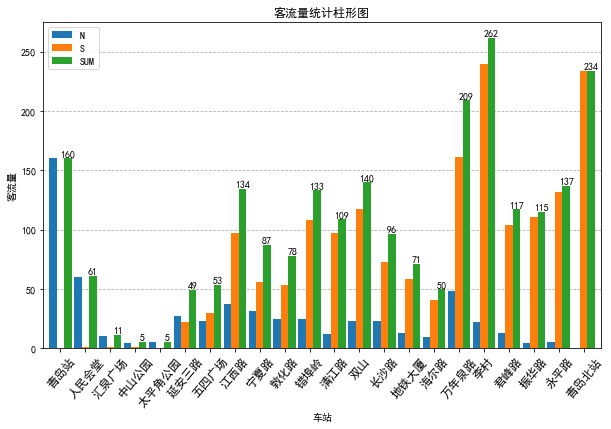

,N,S,SUM
延安三路,27,22,49
五四广场,23,30,53
江西路,37,97,134
宁夏路,31,56,87
敦化路,25,53,78
错埠岭,25,108,133
清江路,12,97,109
双山,23,117,140
长沙路,23,73,96
地铁大厦,13,58,71


In [101]:
def flow(df):  # 统计客流量
    df_n = df[df['start'] > df['end']]
    n_count = df_n['start'].value_counts()  # n_count<series类型>

    df_s = df[df['start'] < df['end']]
    s_count = df_s['start'].value_counts()

    df_mer = pd.DataFrame([s_count, n_count]).T
    df_mer.columns = ['N', 'S']
    # 按列填充空值 法1
    # df_mer.loc[df_mer['N'].isnull(), 'N'] = 0
    df_mer['N'] = df_mer['N'].fillna(0).astype(int)
    df_mer['S'] = df_mer['S'].fillna(0).astype(int)
    df_mer['SUM'] = df_mer.apply(lambda x: x.sum(), axis=1)
    global lin
    lin = list(df_mer.index)    
    df_mer.index = qingdao3
    return df_mer

def bar_chart(df_mer):
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams["grid.linestyle"] = (5,9)
    plt.rcParams['figure.figsize'] = (10, 6)
    df_mer.plot(kind='bar', width=0.9, alpha=1, zorder=1.5) # zorder参数在[1,2]之间也可以将网格线放在图像后
    plt.grid(axis='y', linestyle='--')
    # 在柱子上显示总客流量数据
    for x, y in enumerate(df_mer['SUM']):
        plt.text(x + 0.3, y + 0.5, '%s' % y, ha='center', va='bottom')
    plt.xlabel("车站")
    plt.ylabel("客流量")
    plt.title("客流量统计柱形图")
    plt.xticks(rotation=50)
    plt.legend(loc='upper left')
    plt.tick_params(axis='x', labelsize=12) # 修改标签字体大小
    # plt.rc('axes', axisbelow=True) # 网格线放在图像后
    # plt.savefig('flow.png', dpi=300, bbox_inches='tight') # bbox_inches解决图片显示不全的问题  
    plt.show()  
    
df_merge = flow(d_frame)
bar_chart(df_merge)
df_merge[5:15]


### 三、OD(origin destination)矩阵的制作
通过groupby(),value_counts(),unstack(),pd.DataFrame()
等函数实现。

用热点图表示上车站-下车站的客流更加直观

注：行标签为始发站，列标签为目的站

参考资料:
https://www.jianshu.com/p/42f1d2909bb6


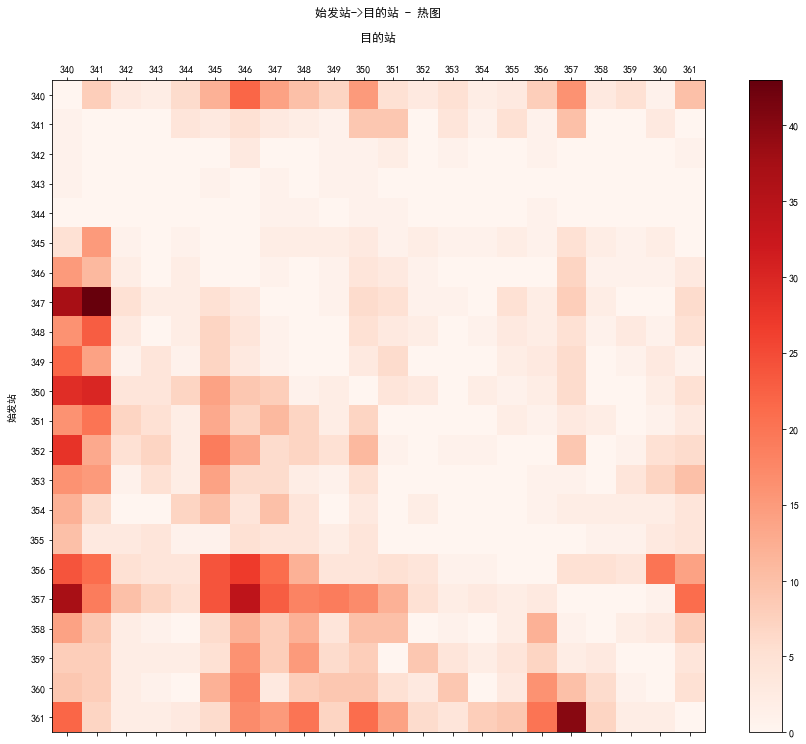

,青岛站,人民会堂,汇泉广场,中山公园,太平角公园,延安三路,五四广场,江西路,宁夏路,敦化路,错埠岭,清江路,双山,长沙路,地铁大厦,海尔路,万年泉路,李村,君峰路,振华路,永平路,青岛北站
青岛站,/,8,3,2,6,12,22,14,10,7,15,5,3,5,2,3,8,16,3,5,1,10
人民会堂,1,/,0,0,4,3,5,3,2,1,9,9,0,4,1,5,1,10,0,0,3,0
汇泉广场,1,0,/,0,0,0,3,0,0,1,1,2,0,1,0,0,1,0,0,0,0,1
中山公园,1,0,0,/,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0
太平角公园,0,0,0,0,/,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0
延安三路,5,15,1,0,1,/,0,2,2,2,3,1,2,1,1,2,1,5,2,1,2,0
五四广场,15,11,2,0,2,0,/,1,0,1,4,3,1,0,0,0,0,7,1,1,1,3
江西路,37,43,5,2,2,5,3,/,0,1,6,5,1,1,0,5,2,8,2,0,0,6
宁夏路,16,23,3,0,2,7,4,1,/,0,5,3,2,0,1,3,2,5,1,3,1,5
敦化路,22,14,1,4,1,7,3,1,0,/,3,6,0,0,0,2,3,6,0,1,3,1


In [82]:
def origin_destination(df):
    # 生成DataFrame时就将数据类型转为int
    df = pd.DataFrame(df.groupby('start')['end'].value_counts().unstack(fill_value=0), dtype=np.int8)
    df.index = lin
    return df

# 绘制热点图
def colormap(df_od):
    fig = plt.figure(figsize=(16, 12)) # 创建自定义图像
    ax = fig.add_subplot(1, 1, 1)  # 创建子图对象
    # ax.set_xticklabels(df_od.index.tolist())  
    # ax.set_yticklabels(df_od.columns.tolist())
    # cax = ax.pcolor(df_od, cmap='Reds') # 方块在两个刻度之间,坐标延申方向不同
    cax = ax.matshow(df_od, cmap='Reds')
    
    fig.colorbar(cax)
    plt.title('始发站->目的站 - 热图\n\n目的站')
    plt.xticks(np.arange(len(lin)), df_od.columns.tolist())  # 设置坐标间隔，使每个车站号都显示出来
    plt.yticks(np.arange(len(lin)), df_od.index.tolist())
    plt.ylabel('始发站\n')
    # plt.savefig('hotmap.png', dpi=300, bbox_inches='tight')
    plt.show()

df_od = origin_destination(d_frame)
colormap(df_od)

pd.set_option('display.max_columns', None) # 显示所有列
for i in lin:
    df_od.loc[i, i] = '/'
df_od.index = qingdao3
df_od.columns = qingdao3
# df_od.to_csv('od.csv')
df_od

